### Importing necessary Modules for database and name generation

In [2]:
from pymongo import MongoClient
import random
import string
import psutil
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import mannwhitneyu

#brew services start mongodb-community@6.0


#### Connecting to the mongodb on standard localhost 

This code connects to the user_info_db database and retrieves the user_info collection


In [3]:
# Connect to MongoDB (default host and port: localhost:27017)
client = MongoClient('mongodb://localhost:27017/')
# Create or access the 'user_info_db' database
db = client['user_info_db']

Initializing the collections used



In [4]:
collection_50 = db['user_info_50']
collection_500 = db['user_info_500']
collection_5000 = db['user_info_5000']

classical_search_50 = db['classical_search_50']
classical_search_500 = db['classical_search_500']
classical_search_5000 = db['classical_search_5000']


grover_search_50 = db['grover_search_50']  
grover_search_500 = db['grover_search_500']
grover_search_5000 = db['grover_search_5000']


Helper function to generate names

In [5]:
def generate_random_name(length=6):
    """Generate a random name of a specified length"""
    return ''.join(random.choices(string.ascii_uppercase, k=length))

### All collection insertions

In [6]:
# Insertion function for 'user_info_50'
def insert_user_info_50():
    collection_50.delete_many({})  # Clear any existing data
    names_50 = [{"name": generate_random_name()} for _ in range(50)]
    collection_50.insert_many(names_50)
    print("Inserted 50 names into user_info_50.")

# Insertion function for 'user_info_500'
def insert_user_info_500():
    collection_500.delete_many({})  # Clear any existing data
    names_500 = [{"name": generate_random_name()} for _ in range(500)]
    collection_500.insert_many(names_500)
    print("Inserted 500 names into user_info_500.")

# Insertion function for 'user_info_5000'
def insert_user_info_5000():
    collection_5000.delete_many({})  # Clear any existing data
    names_5000 = [{"name": generate_random_name()} for _ in range(5000)]
    collection_5000.insert_many(names_5000)
    print("Inserted 5000 names into user_info_5000.")

# inserting
insert_user_info_50()
insert_user_info_500()
insert_user_info_5000()



Inserted 50 names into user_info_50.
Inserted 500 names into user_info_500.
Inserted 5000 names into user_info_5000.


### Creating the target lists

In [7]:
# Step 2: Create the target name lists
# Helper function to create target lists (existing + non-existing names)
def create_target_name_list(collection_name, total_names):
    collection = db[collection_name]
    existing_names = [user["name"] for user in collection.find()]
    print(f"Existing names in {collection_name}: {existing_names[:10]}")  # Displaying first 10 names for inspection
    
    # Generate non-existing names
    new_non_existing_names = set()
    while len(new_non_existing_names) < total_names // 2:  # Half will be non-existing
        new_name = generate_random_name()
        if new_name not in existing_names:
            new_non_existing_names.add(new_name)
    
    target_name_list = existing_names[:total_names // 2] + list(new_non_existing_names)
    random.shuffle(target_name_list)  # Shuffle the list to mix existing and new names
    return target_name_list

# Creating target name lists
target_name_list_50 = create_target_name_list('user_info_50', 100)
target_name_list_500 = create_target_name_list('user_info_500', 1000)
target_name_list_5000 = create_target_name_list('user_info_5000', 10000)

# Verifying the lists
print(f"Target name list for user_info_50 (100 names): {target_name_list_50[:10]}...")  # Displaying first 10 names for inspection
print(f"Target name list for user_info_500 (1000 names): {target_name_list_500[:10]}...")
print(f"Target name list for user_info_5000 (10000 names): {target_name_list_5000[:10]}...")

Existing names in user_info_50: ['DWRNGN', 'NSPMAJ', 'GIBXSX', 'HHOAGQ', 'DRXVOH', 'TUECSW', 'IRUJTV', 'FUXEMW', 'HDVACP', 'TNOTUP']
Existing names in user_info_500: ['RVCLTU', 'AHEKOC', 'QWHURM', 'HLYJVV', 'JFXHKF', 'YIPAUN', 'IGJVRQ', 'DPPJQD', 'FRFKBA', 'NEQYXP']
Existing names in user_info_5000: ['XDKGTM', 'PRSAPF', 'KBJLWC', 'YSMANB', 'TBRSCA', 'THDQYG', 'HDTIEM', 'RFPYZN', 'DEBSDX', 'DRIVAL']
Target name list for user_info_50 (100 names): ['AGAUPR', 'YZORQU', 'TAIBIQ', 'JKLLDG', 'IPMQLQ', 'VOLJMT', 'NSPMAJ', 'NESTNG', 'TOIWAV', 'VNYZPI']...
Target name list for user_info_500 (1000 names): ['QKKOIZ', 'QEWKFA', 'JVWRIH', 'UQOVNE', 'SPIYBI', 'LCTYKP', 'VTLMEQ', 'VHMTBO', 'XACRDA', 'YENCJR']...
Target name list for user_info_5000 (10000 names): ['KATNAO', 'IZXQBO', 'VEANGR', 'BNOODX', 'FCAXIC', 'WSBFLW', 'VOYPZV', 'JTIFEW', 'YYOYVS', 'YVYGPG']...


## Classical Approach O(N)

In [29]:
def classical_search(collection, target_name):
    # Start CPU and memory usage tracking
    cpu_start = psutil.cpu_percent(interval=0.01)
    memory_start = psutil.virtual_memory().used / (1024 * 1024)  # Memory in MB
    start_time = time.perf_counter()

    found = False
    comparisons = 0
    for user in collection.find():
        comparisons += 1
        if user["name"] == target_name:
            found = True
            break

    end_time = time.perf_counter()
    time_taken_sec = end_time - start_time  # Time in seconds

    # End CPU and memory usage tracking
    cpu_end = psutil.cpu_percent(interval=None)
    memory_end = psutil.virtual_memory().used / (1024 * 1024)  # Memory in MB

    # Calculate memory usage in MB
    memory_usage = memory_end - memory_start  # Memory usage in MB

    print(f"Time for search of {target_name}: {time_taken_sec:.6f} seconds")  # Debugging individual time for search
    
    # Return all metrics (including start-end CPU and memory usage)
    return found, time_taken_sec, comparisons, cpu_end - cpu_start, memory_usage

# Insert search results into the classical_search_xxxx collection
def insert_search_results(collection_name, target_name, found, time_taken, comparisons, cpu_usage, memory_usage):
    collection = db[collection_name]
    
    collection.insert_one({
        'name': target_name,
        'found': found,
        'TimeTaken': time_taken,  # Time in seconds
        'Comparisons': comparisons,
        'CPUUsage': cpu_usage,  # CPU usage during the search (difference)
        'MemoryUsage': memory_usage  # Memory usage during the search (in MB)
    })

# Function to insert average metrics for classical search (CPU, memory, total time)
def insert_average_metrics(collection_name, total_time, avg_cpu_usage, avg_memory_usage, search_count):
    collection = db['classical_average_metrics']
    
    collection.insert_one({
        'collection': collection_name,
        'TotalTime': total_time,  # Total time in seconds
        'AvgCPUUsage': avg_cpu_usage,  # Average CPU usage
        'AvgMemoryUsage': avg_memory_usage,  # Average Memory usage in MB
        'SearchCount': search_count  # Number of searches performed
    })

# Classical search for the target lists and store results
def run_classical_search():
    # Initialize total time and resource usage trackers
    total_time_50 = total_time_500 = total_time_5000 = 0
    total_cpu_usage_50 = total_cpu_usage_500 = total_cpu_usage_5000 = 0
    total_memory_usage_50 = total_memory_usage_500 = total_memory_usage_5000 = 0
    total_comparisons_50 = total_comparisons_500 = total_comparisons_5000 = 0

    # Process for user_info_50
    classical_search_50.delete_many({})
    start_time_50 = time.perf_counter()
    for target_name in target_name_list_50:
        found, time_taken, comparisons, cpu_usage, memory_usage = classical_search(collection_50, target_name)
        insert_search_results('classical_search_50', target_name, found, time_taken, comparisons, cpu_usage, memory_usage)
        total_comparisons_50 += comparisons
        total_cpu_usage_50 += cpu_usage
        total_memory_usage_50 += memory_usage
        total_time_50 += time_taken
    end_time_50 = time.perf_counter()

    # Process for user_info_500
    classical_search_500.delete_many({})
    start_time_500 = time.perf_counter()
    for target_name in target_name_list_500:
        found, time_taken, comparisons, cpu_usage, memory_usage = classical_search(collection_500, target_name)
        insert_search_results('classical_search_500', target_name, found, time_taken, comparisons, cpu_usage, memory_usage)
        total_comparisons_500 += comparisons
        total_cpu_usage_500 += cpu_usage
        total_memory_usage_500 += memory_usage
        total_time_500 += time_taken
    end_time_500 = time.perf_counter()

    # Process for user_info_5000
    classical_search_5000.delete_many({})
    start_time_5000 = time.perf_counter()
    for target_name in target_name_list_5000:
        found, time_taken, comparisons, cpu_usage, memory_usage = classical_search(collection_5000, target_name)
        insert_search_results('classical_search_5000', target_name, found, time_taken, comparisons, cpu_usage, memory_usage)
        total_comparisons_5000 += comparisons
        total_cpu_usage_5000 += cpu_usage
        total_memory_usage_5000 += memory_usage
        total_time_5000 += time_taken
    end_time_5000 = time.perf_counter()

    # Calculate average CPU usage, memory usage for each collection
    avg_cpu_usage_50 = total_cpu_usage_50 / len(target_name_list_50)
    avg_memory_usage_50 = total_memory_usage_50 / len(target_name_list_50)
    avg_cpu_usage_500 = total_cpu_usage_500 / len(target_name_list_500)
    avg_memory_usage_500 = total_memory_usage_500 / len(target_name_list_500)
    avg_cpu_usage_5000 = total_cpu_usage_5000 / len(target_name_list_5000)
    avg_memory_usage_5000 = total_memory_usage_5000 / len(target_name_list_5000)

    # Insert average metrics for each collection into the classical_average_metrics collection
    insert_average_metrics('user_info_50', total_time_50, avg_cpu_usage_50, avg_memory_usage_50, len(target_name_list_50))
    insert_average_metrics('user_info_500', total_time_500, avg_cpu_usage_500, avg_memory_usage_500, len(target_name_list_500))
    insert_average_metrics('user_info_5000', total_time_5000, avg_cpu_usage_5000, avg_memory_usage_5000, len(target_name_list_5000))

# Run the classical search and insert results
run_classical_search()


Time for search of BBOQGK: 0.000825 seconds
Time for search of BRSTNE: 0.000444 seconds
Time for search of MHHJES: 0.000323 seconds
Time for search of CLJPBZ: 0.000431 seconds
Time for search of YEGRLG: 0.000852 seconds
Time for search of DUOWOR: 0.000338 seconds
Time for search of TNSNUV: 0.000911 seconds
Time for search of YFTKYP: 0.000481 seconds
Time for search of PFFZPH: 0.000440 seconds
Time for search of MDWLOK: 0.000606 seconds
Time for search of IRINCA: 0.000393 seconds
Time for search of KSBFBI: 0.000324 seconds
Time for search of GZDPOZ: 0.000296 seconds
Time for search of HRELIH: 0.000292 seconds
Time for search of OQQDFG: 0.000291 seconds
Time for search of TFZNRU: 0.000338 seconds
Time for search of KZSBHB: 0.000349 seconds
Time for search of XYASYA: 0.000286 seconds
Time for search of YYBHNF: 0.000292 seconds
Time for search of QTFHOY: 0.000284 seconds
Time for search of JAPBVG: 0.000288 seconds
Time for search of FZMXOK: 0.000459 seconds
Time for search of BJBADP: 0.000

### Organizing the data

In [30]:
# Function to retrieve data from a collection (classical_search_xxxx collections)
def get_search_data(collection_name):
    collection = db[collection_name]
    search_results = collection.find()  # Query all documents
    return list(search_results)

# Retrieve data for all three collections (classical_search_xxxx)
data_50 = get_search_data('classical_search_50')
data_500 = get_search_data('classical_search_500')
data_5000 = get_search_data('classical_search_5000')

# Function to retrieve average metrics from the 'classical_average_metrics' collection
def get_average_metrics(collection_name):
    collection = db['classical_average_metrics']
    avg_metrics = collection.find_one({'collection': collection_name})
    return avg_metrics

# Retrieve average metrics for all collections (classical_average_metrics)
average_metrics_50 = get_average_metrics('user_info_50')
average_metrics_500 = get_average_metrics('user_info_500')
average_metrics_5000 = get_average_metrics('user_info_5000')

# Extract the relevant metrics from the search results
def extract_metrics(data):
    times = []
    found = []
    comparisons = []
    names_searched_per_sec = []
    cpu_usages = []
    memory_usages = []

    for record in data:
        # Extract the required fields for plotting
        times.append(record['TimeTaken'])  # Time taken for the search (seconds)
        found.append(record['found'])  # Whether the target was found (True/False)
        comparisons.append(record['Comparisons'])  # Number of comparisons made during search
        if 'NamesSearchedPerSecond' in record:
            names_searched_per_sec.append(record['NamesSearchedPerSecond'])  # Names searched per second
        else:
            names_searched_per_sec.append(None)  # Handle missing data gracefully
        
        cpu_usages.append(record['CPUUsage'])  # CPU usage during search (difference)
        memory_usages.append(record['MemoryUsage'])  # Memory usage during search (difference)
    
    return times, found, comparisons, names_searched_per_sec, cpu_usages, memory_usages

# Extract data for each collection (classical_search_xxxx collections)
times_50, found_50, comparisons_50, names_searched_per_sec_50, cpu_usages_50, memory_usages_50 = extract_metrics(data_50)
times_500, found_500, comparisons_500, names_searched_per_sec_500, cpu_usages_500, memory_usages_500 = extract_metrics(data_500)
times_5000, found_5000, comparisons_5000, names_searched_per_sec_5000, cpu_usages_5000, memory_usages_5000 = extract_metrics(data_5000)

# Extract average metrics for visualization (from the classical_average_metrics collection)
total_time_50 = average_metrics_50.get('TotalTime', 0)
avg_cpu_50 = average_metrics_50.get('AvgCPUUsage', 0)
avg_memory_50 = average_metrics_50.get('AvgMemoryUsage', 0)

total_time_500 = average_metrics_500.get('TotalTime', 0)
avg_cpu_500 = average_metrics_500.get('AvgCPUUsage', 0)
avg_memory_500 = average_metrics_500.get('AvgMemoryUsage', 0)

total_time_5000 = average_metrics_5000.get('TotalTime', 0)
avg_cpu_5000 = average_metrics_5000.get('AvgCPUUsage', 0)
avg_memory_5000 = average_metrics_5000.get('AvgMemoryUsage', 0)

# Now calculate the rate of searches per second for each collection
searches_per_sec_50 = len(data_50) / total_time_50 if total_time_50 > 0 else 0
searches_per_sec_500 = len(data_500) / total_time_500 if total_time_500 > 0 else 0
searches_per_sec_5000 = len(data_5000) / total_time_5000 if total_time_5000 > 0 else 0


Total Time for 50 collection: 0.05525058921193704 seconds
Search count for 50 collection: 100
Searches per second for 50 collection: 1809.9354491299205
Total Time for 500 collection: 3.466095549054444 seconds
Search count for 500 collection: 1000
Searches per second for 500 collection: 288.5090690222898
Total Time for 5000 collection: 231.37855940085137 seconds
Search count for 5000 collection: 10000
Searches per second for 5000 collection: 43.21921627438054


### Plotting the data

Time it took to search through the different data sets

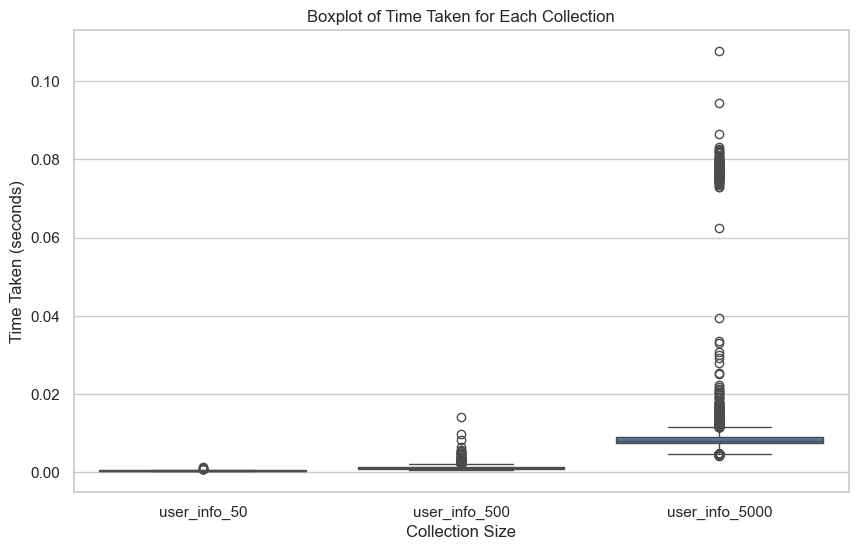

['user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_info_50', 'user_i

In [ ]:
# Function to visualize the Boxplot of Time Taken
def plot_time_taken(times_50, times_500, times_5000):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=["user_info_50"] * len(times_50) + ["user_info_500"] * len(times_500) + ["user_info_5000"] * len(times_5000),
                y=times_50 + times_500 + times_5000)
    plt.xlabel("Collection Size")
    plt.ylabel("Time Taken (seconds)")
    plt.title("Boxplot of Time Taken for Each Collection")
    plt.show()

plot_time_taken(times_50, times_500, times_5000)


Average number of comparisons in each dataset

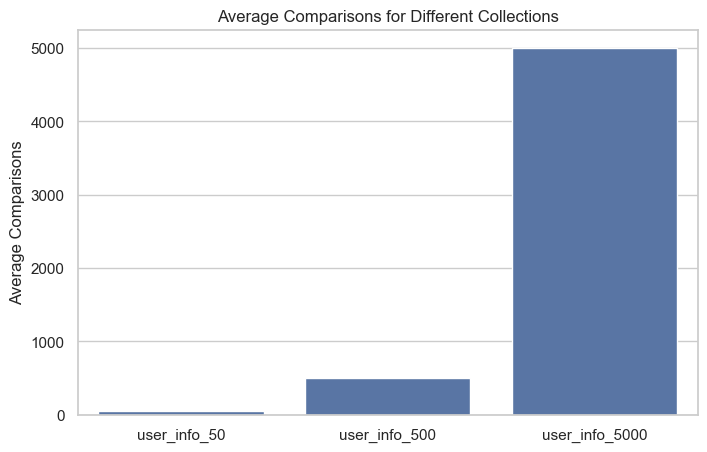

Average Comparisons for user_info_50: 50.0
Average Comparisons for user_info_500: 500.0
Average Comparisons for user_info_5000: 5000.0


In [35]:
# Function to visualize the Average Comparisons with Bar Plot
def plot_average_comparisons(comparisons_50, comparisons_500, comparisons_5000):
    avg_comparisons_50 = np.mean(comparisons_50)
    avg_comparisons_500 = np.mean(comparisons_500)
    avg_comparisons_5000 = np.mean(comparisons_5000)

    plt.figure(figsize=(8, 5))
    sns.barplot(x=["user_info_50", "user_info_500", "user_info_5000"], y=[avg_comparisons_50, avg_comparisons_500, avg_comparisons_5000])
    plt.ylabel("Average Comparisons")
    plt.title("Average Comparisons for Different Collections")
    plt.show()

    print(f"Average Comparisons for user_info_50: {avg_comparisons_50}")
    print(f"Average Comparisons for user_info_500: {avg_comparisons_500}")
    print(f"Average Comparisons for user_info_5000: {avg_comparisons_5000}")

# Plot Average Comparisons Bar Plot
plot_average_comparisons(comparisons_50, comparisons_500, comparisons_5000)


Number of names searched per second

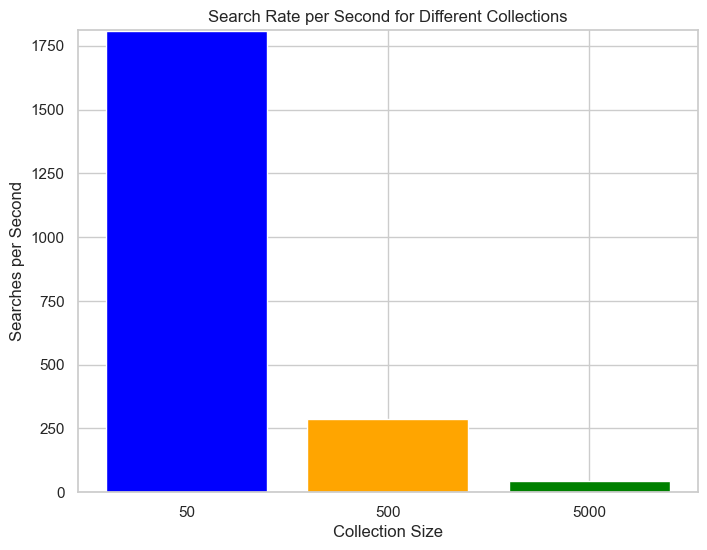

In [37]:
def plot_names_searched_per_sec():
    # Data for plotting
    collections = ['50', '500', '5000']
    search_rates = [searches_per_sec_50, searches_per_sec_500, searches_per_sec_5000]

    # Plotting the bar chart for searches per second
    plt.figure(figsize=(8, 6))
    plt.bar(collections, search_rates, color=['blue', 'orange', 'green'])
    plt.xlabel('Collection Size')
    plt.ylabel('Searches per Second')
    plt.title('Search Rate per Second for Different Collections')
    plt.ylim(0, max(search_rates) + 1)  # Set the y-axis limit to have some space above the bars
    plt.show()

# plotting the rate of searches per second
plot_names_searched_per_sec()

CPU usage

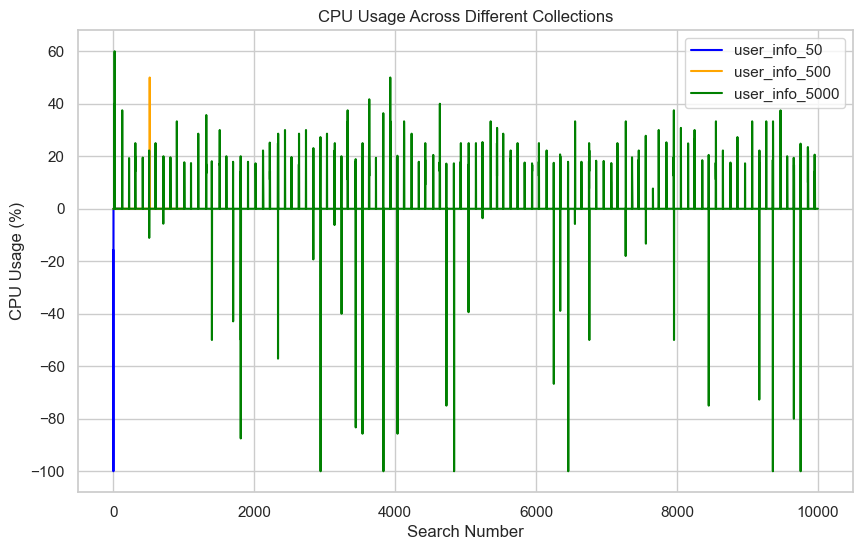

In [38]:
# Function to visualize CPU Usage with Line Plot
def plot_cpu_usage(cpu_usages_50, cpu_usages_500, cpu_usages_5000):
    plt.figure(figsize=(10, 6))
    plt.plot(cpu_usages_50, label="user_info_50", color="blue")
    plt.plot(cpu_usages_500, label="user_info_500", color="orange")
    plt.plot(cpu_usages_5000, label="user_info_5000", color="green")
    plt.xlabel("Search Number")
    plt.ylabel("CPU Usage (%)")
    plt.title("CPU Usage Across Different Collections")
    plt.legend()
    plt.show()

plot_cpu_usage(cpu_usages_50, cpu_usages_500, cpu_usages_5000)


Memory usage

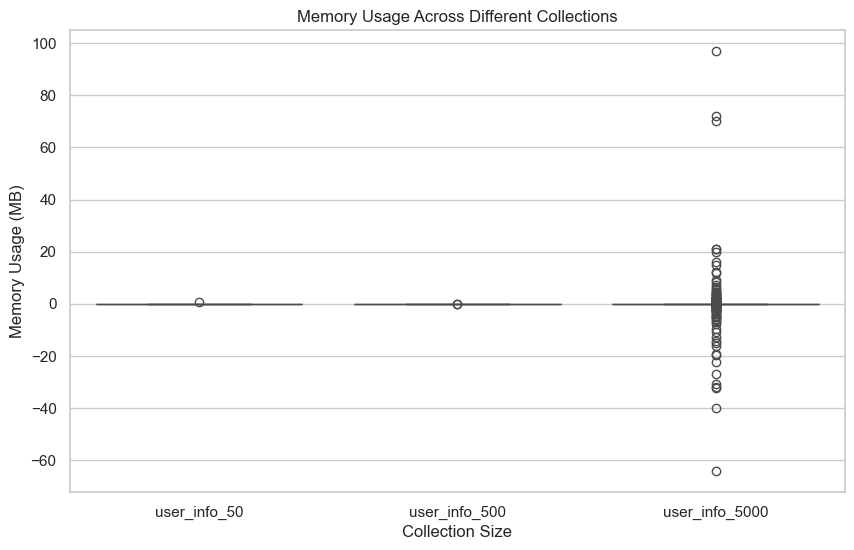

In [42]:
# Function to visualize Memory Usage with Box Plot
def plot_memory_usage(memory_usages_50, memory_usages_500, memory_usages_5000):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=["user_info_50"] * len(memory_usages_50) + ["user_info_500"] * len(memory_usages_500) + ["user_info_5000"] * len(memory_usages_5000),
                y=memory_usages_50 + memory_usages_500 + memory_usages_5000)
    plt.xlabel("Collection Size")
    plt.ylabel("Memory Usage (MB)")
    plt.title("Memory Usage Across Different Collections")
    plt.show()

plot_memory_usage(memory_usages_50, memory_usages_500, memory_usages_5000)


Total time taken for each data set

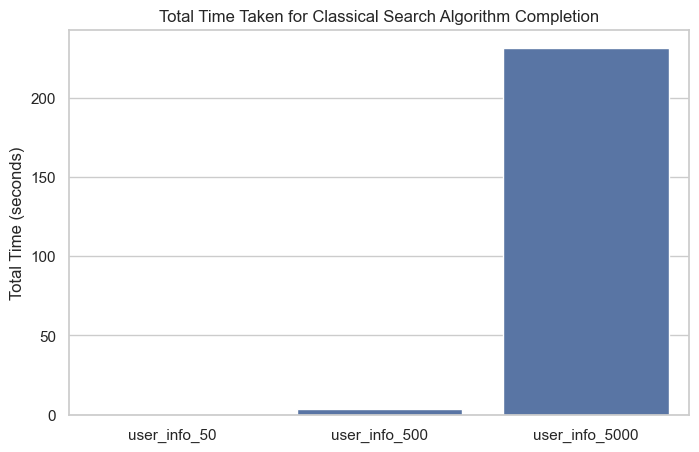

In [43]:
# Function to visualize Total Time Taken with Bar Plot
def plot_total_time(total_time_50, total_time_500, total_time_5000):
    total_times = [total_time_50, total_time_500, total_time_5000]
    collections = ['user_info_50', 'user_info_500', 'user_info_5000']

    plt.figure(figsize=(8, 5))
    sns.barplot(x=collections, y=total_times)
    plt.ylabel("Total Time (seconds)")
    plt.title("Total Time Taken for Classical Search Algorithm Completion")
    plt.show()

plot_total_time(total_time_50, total_time_500, total_time_5000)

### STATS

In [19]:
# Function to print relevant statistics
def print_stats(collection_name):
    collection = db[collection_name]
    data = list(collection.find())
    df = pd.DataFrame(data)  # Convert data to DataFrame

    print(f"\nStatistics for {collection_name}:")

    # TimeTaken Stats
    mean_time = df['TimeTaken'].mean()
    median_time = df['TimeTaken'].median()
    std_dev_time = df['TimeTaken'].std()
    min_time = df['TimeTaken'].min()
    max_time = df['TimeTaken'].max()
    iqr_time = df['TimeTaken'].quantile(0.75) - df['TimeTaken'].quantile(0.25)

    print(f"Mean Time: {mean_time:.5f} s")
    print(f"Median Time: {median_time:.5f} s")
    print(f"Standard Deviation: {std_dev_time:.5f} s")
    print(f"Min Time: {min_time:.5f} s")
    print(f"Max Time: {max_time:.5f} s")
    print(f"IQR (Interquartile Range): {iqr_time:.5f} s")

    # Comparisons Stats
    mean_comparisons = df['Comparisons'].mean()
    median_comparisons = df['Comparisons'].median()
    std_dev_comparisons = df['Comparisons'].std()
    min_comparisons = df['Comparisons'].min()
    max_comparisons = df['Comparisons'].max()
    iqr_comparisons = df['Comparisons'].quantile(0.75) - df['Comparisons'].quantile(0.25)

    print(f"\nMean Comparisons: {mean_comparisons:.5f}")
    print(f"Median Comparisons: {median_comparisons:.5f}")
    print(f"Standard Deviation: {std_dev_comparisons:.5f}")
    print(f"Min Comparisons: {min_comparisons:.5f}")
    print(f"Max Comparisons: {max_comparisons:.5f}")
    print(f"IQR (Interquartile Range): {iqr_comparisons:.5f}")

    # Memory Usage Stats
    mean_memory_usage = df['MemoryUsage'].mean()
    median_memory_usage = df['MemoryUsage'].median()
    std_dev_memory_usage = df['MemoryUsage'].std()
    min_memory_usage = df['MemoryUsage'].min()
    max_memory_usage = df['MemoryUsage'].max()
    iqr_memory_usage = df['MemoryUsage'].quantile(0.75) - df['MemoryUsage'].quantile(0.25)

    print(f"\nMean Memory Usage: {mean_memory_usage:.5f} MB")
    print(f"Median Memory Usage: {median_memory_usage:.5f} MB")
    print(f"Standard Deviation: {std_dev_memory_usage:.5f} MB")
    print(f"Min Memory Usage: {min_memory_usage:.5f} MB")
    print(f"Max Memory Usage: {max_memory_usage:.5f} MB")
    print(f"IQR (Interquartile Range): {iqr_memory_usage:.5f} MB")

    # CPU Usage Stats
    mean_cpu_usage = df['CPUUsage'].mean()
    median_cpu_usage = df['CPUUsage'].median()
    std_dev_cpu_usage = df['CPUUsage'].std()
    min_cpu_usage = df['CPUUsage'].min()
    max_cpu_usage = df['CPUUsage'].max()
    iqr_cpu_usage = df['CPUUsage'].quantile(0.75) - df['CPUUsage'].quantile(0.25)

    print(f"\nMean CPU Usage: {mean_cpu_usage:.5f} %")
    print(f"Median CPU Usage: {median_cpu_usage:.5f} %")
    print(f"Standard Deviation: {std_dev_cpu_usage:.5f} %")
    print(f"Min CPU Usage: {min_cpu_usage:.5f} %")
    print(f"Max CPU Usage: {max_cpu_usage:.5f} %")
    print(f"IQR (Interquartile Range): {iqr_cpu_usage:.5f} %")

# Print stats for each collection
print_stats('classical_search_50')
print_stats('classical_search_500')
print_stats('classical_search_5000')



Statistics for classical_search_50:
Mean Time: 0.00055 s
Median Time: 0.00041 s
Standard Deviation: 0.00065 s
Min Time: 0.00028 s
Max Time: 0.00480 s
IQR (Interquartile Range): 0.00012 s

Mean Comparisons: 50.50000
Median Comparisons: 50.50000
Standard Deviation: 29.01149
Min Comparisons: 1.00000
Max Comparisons: 100.00000
IQR (Interquartile Range): 49.50000

Mean Memory Usage: 0.00000 MB
Median Memory Usage: 0.00000 MB
Standard Deviation: 0.00000 MB
Min Memory Usage: 0.00000 MB
Max Memory Usage: 0.00000 MB
IQR (Interquartile Range): 0.00000 MB

Mean CPU Usage: -0.16200 %
Median CPU Usage: 0.00000 %
Standard Deviation: 1.62000 %
Min CPU Usage: -16.20000 %
Max CPU Usage: 0.00000 %
IQR (Interquartile Range): 0.00000 %

Statistics for classical_search_500:
Mean Time: 0.00347 s
Median Time: 0.00293 s
Standard Deviation: 0.00267 s
Min Time: 0.00021 s
Max Time: 0.03928 s
IQR (Interquartile Range): 0.00174 s

Mean Comparisons: 500.50000
Median Comparisons: 500.50000
Standard Deviation: 288.8

## Grovers Search below

In [8]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit.circuit.library import MCXGate

In [15]:
def grover_search_algorithm(collection, target_name_list, grover_collection):
    names = [user["name"] for user in collection.find()]
    # Create a mapping of the names to indices for quantum representation
    name_to_index = {name: i for i, name in enumerate(names)}
    grover_collection.delete_many({})

    # Number of qubits needed is based on the number of possible names
    n = len(names)  # number of names in the database
    n_qubits = int(np.ceil(np.log2(n))) # number of qubits needed
    print(f"number of qubits: {n_qubits}")
    # Grover's Oracle: Phase-flip (controlled-Z gate) for the target state
    def grover_oracle(circuit, n_qubits, target_index):
        """Mark the state corresponding to the target index (the solution) with a phase flip."""
        for qubit in range(n_qubits):
            if (target_index >> qubit) & 1:
                circuit.x(qubit)

        circuit.h(n_qubits - 1)
        circuit.mcx(list(range(n_qubits - 1)), n_qubits - 1)  # Multi-controlled Toffoli (MCX)
        circuit.h(n_qubits - 1)

        for qubit in range(n_qubits):
            if (target_index >> qubit) & 1:
                circuit.x(qubit)

    # Grover's Diffusion Operator: Inversion about the mean
    def grover_diffusion(circuit, n_qubits):
        """Apply the diffusion operator."""
        for qubit in range(n_qubits):
            circuit.h(qubit)
            circuit.x(qubit)

        circuit.h(n_qubits - 1)
        circuit.mcx(list(range(n_qubits - 1)), n_qubits - 1)
        circuit.h(n_qubits - 1)

        for qubit in range(n_qubits):
            circuit.x(qubit)
            circuit.h(qubit)

    # Function to insert search results into MongoDB
    def insert_search_result(target_name, found, time_taken, cpu_usage, memory_usage, comparisons):
        """Insert the search result into the appropriate MongoDB collection"""
        document = {
            "TargetName": target_name,
            "Found": found,
            "TimeTaken": time_taken,
            "CPUUsage": cpu_usage,  # CPU usage during the search
            "MemoryUsage": memory_usage,  # Memory usage during the search (in MB)
            "Comparisons": comparisons  # Track the number of Grover iterations as comparisons
        }
        grover_collection.insert_one(document)

    # Grover's search algorithm with insertion into MongoDB
    def grover_search_and_insert(names, target_name):
        # Initialize the quantum circuit
        n = len(names)
        n_qubits = n.bit_length()  # Number of qubits needed for the database size
        qc = QuantumCircuit(n_qubits, n_qubits)
        
        # Apply Hadamard to all qubits to create the superposition
        qc.h(range(n_qubits))
        
        # Perform Grover's algorithm iterations
        target_index = name_to_index.get(target_name, None)
        
        # Handle the case when the target name is not found
        if target_index is None:
            found = False
        else:
            # Apply Grover's Oracle and Diffusion operator
            grover_oracle(qc, n_qubits, target_index)
            grover_diffusion(qc, n_qubits)
            found = True
        
        # Measure the qubits
        qc.measure(range(n_qubits), range(n_qubits))
        
        # Use the Aer's qasm_simulator to simulate the result
        simulator = AerSimulator()
        
        # Start CPU and memory tracking
        cpu_start = psutil.cpu_percent(interval=None)
        memory_start = psutil.virtual_memory().used / (1024 * 1024)  # Memory in MB
        start_time = time.perf_counter()  # Start time for execution
        
        result = simulator.run(qc, shots=1024).result()
        elapsed_time_ms = (time.perf_counter() - start_time)  # Time in seconds
        
        # End CPU and memory tracking
        cpu_end = psutil.cpu_percent(interval=None)
        memory_end = psutil.virtual_memory().used / (1024 * 1024)  # Memory in MB
        
        cpu_usage = cpu_end - cpu_start
        memory_usage = memory_end - memory_start
        
        # Count Grover iterations (as comparisons)
        comparisons = 1  # Grover's algorithm usually does one iteration; we can modify based on number of iterations
        
        # Display the results (showing only key output)
        counts = result.get_counts(qc)
        
        if found:
            binary_target = format(target_index, '0{}b'.format(n_qubits))
            found_in_results = binary_target in counts
        
        # Insert the search result into the MongoDB collection
        insert_search_result(target_name, found, elapsed_time_ms, cpu_usage, memory_usage, comparisons)

    # Loop through the list of target names and perform Grover's search
    for target_name in target_name_list:
        grover_search_and_insert(names, target_name)

# Perform Grover search for each collection with their respective target name lists
grover_search_algorithm(collection_50, target_name_list_50, grover_search_50)
grover_search_algorithm(collection_500, target_name_list_500, grover_search_500)
grover_search_algorithm(collection_5000, target_name_list_5000, grover_search_5000)

print("Grover finished")


number of qubits: 6
number of qubits: 9
number of qubits: 13
Grover finished


### Organizing the data

In [18]:
# Function to retrieve data from a collection
def get_search_data(collection_name):
    collection = db[collection_name]
    search_results = collection.find()  # Query all documents
    return list(search_results)

# Retrieve data for the grover_search_50, grover_search_500, and grover_search_5000 collections
data_grover_50 = get_search_data('grover_search_50')
data_grover_500 = get_search_data('grover_search_500')
data_grover_5000 = get_search_data('grover_search_5000')

# Extract times and found status for plotting
def extract_times_and_found_status(data):
    times = []
    found = []
    for record in data:
        times.append(record['TimeTaken'])  # Assuming field is named 'TimeTaken' in seconds
        found.append(record['Found'])  # Assuming field is named 'Found'
    return times, found

# Extract data for all three collections
times_grover_50, found_grover_50 = extract_times_and_found_status(data_grover_50)
times_grover_500, found_grover_500 = extract_times_and_found_status(data_grover_500)
times_grover_5000, found_grover_5000 = extract_times_and_found_status(data_grover_5000)


### Plotting the data

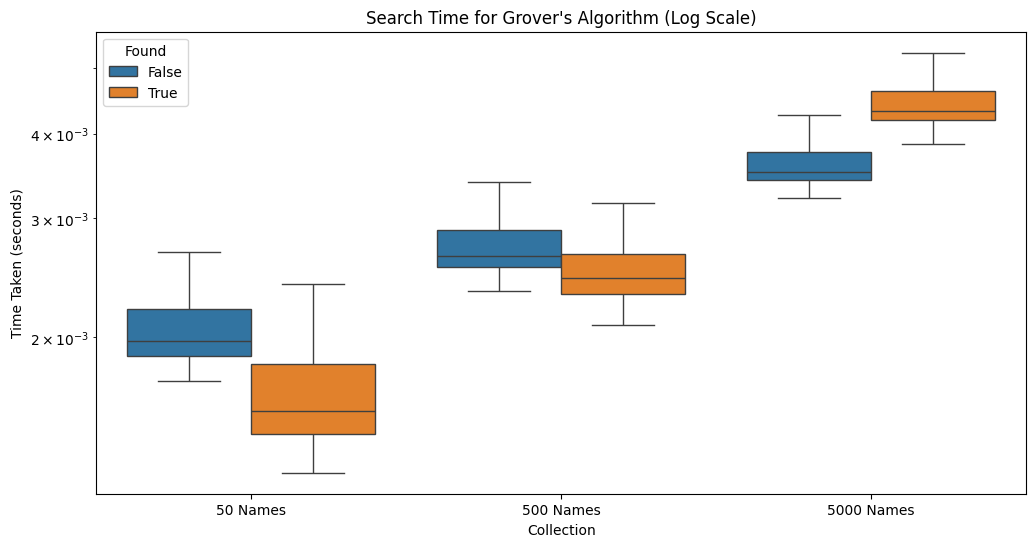

In [20]:
# Function to create DataFrame for plotting
def create_df_for_plot(times, found, collection_name):
    df = pd.DataFrame({
        'Time Taken (seconds)': times,  # Show time in seconds
        'Found': found,
        'Collection': [collection_name] * len(times)
    })
    return df

# Create DataFrames for all collections
df_grover_50 = create_df_for_plot(times_grover_50, found_grover_50, '50 Names')
df_grover_500 = create_df_for_plot(times_grover_500, found_grover_500, '500 Names')
df_grover_5000 = create_df_for_plot(times_grover_5000, found_grover_5000, '5000 Names')

# Combine the DataFrames
df_all = pd.concat([df_grover_50, df_grover_500, df_grover_5000], ignore_index=True)

# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(x='Collection', y='Time Taken (seconds)', hue='Found', data=df_all, showfliers=False)
plt.yscale('log')  # Apply logarithmic scale
plt.title('Search Time for Grover\'s Algorithm (Log Scale)')
plt.ylabel('Time Taken (seconds)')
plt.show()


### Statistical information

In [23]:
# Assuming df_grover_50, df_grover_500, and df_grover_5000 are already available from previous code

# Function to calculate and print stats (now in seconds)
def print_stats(collection_name, df):
    print(f"\nStatistics for {collection_name}:")
    mean = df['Time Taken (seconds)'].mean()  # In seconds
    median = df['Time Taken (seconds)'].median()
    std_dev = df['Time Taken (seconds)'].std()
    min_val = df['Time Taken (seconds)'].min()
    max_val = df['Time Taken (seconds)'].max()
    iqr = df['Time Taken (seconds)'].quantile(0.75) - df['Time Taken (seconds)'].quantile(0.25)

    print(f"Mean Time: {mean:.5f} s")
    print(f"Median Time: {median:.5f} s")
    print(f"Standard Deviation: {std_dev:.5f} s")
    print(f"Min Time: {min_val:.5f} s")
    print(f"Max Time: {max_val:.5f} s")
    print(f"IQR (Interquartile Range): {iqr:.5f} s")


# Mann-Whitney U test function to compare found vs not found (using seconds)
def mann_whitney_test(collection_df):
    found_times = collection_df[collection_df['Found'] == True]['Time Taken (seconds)']
    not_found_times = collection_df[collection_df['Found'] == False]['Time Taken (seconds)']
    stat, p_value = mannwhitneyu(found_times, not_found_times, alternative='two-sided')
    return p_value

# Print stats for grover_search_50, grover_search_500, and grover_search_5000 collections
print_stats('grover_search_50', df_grover_50)
print_stats('grover_search_500', df_grover_500)
print_stats('grover_search_5000', df_grover_5000)

# Perform Mann-Whitney U test for each collection
p_value_50 = mann_whitney_test(df_grover_50)
p_value_500 = mann_whitney_test(df_grover_500)
p_value_5000 = mann_whitney_test(df_grover_5000)

# Print p-values for each collection
print(f"\nP-Value for grover_search_50: {p_value_50:.5f}")
print(f"P-Value for grover_search_500: {p_value_500:.5f}")
print(f"P-Value for grover_search_5000: {p_value_5000:.5f}")



Statistics for grover_search_50:
Mean Time: 0.00196 s
Median Time: 0.00187 s
Standard Deviation: 0.00084 s
Min Time: 0.00126 s
Max Time: 0.00921 s
IQR (Interquartile Range): 0.00056 s

Statistics for grover_search_500:
Mean Time: 0.00270 s
Median Time: 0.00257 s
Standard Deviation: 0.00100 s
Min Time: 0.00209 s
Max Time: 0.03000 s
IQR (Interquartile Range): 0.00033 s

Statistics for grover_search_5000:
Mean Time: 0.00425 s
Median Time: 0.00414 s
Standard Deviation: 0.00118 s
Min Time: 0.00322 s
Max Time: 0.03109 s
IQR (Interquartile Range): 0.00089 s

P-Value for grover_search_50: 0.00000
P-Value for grover_search_500: 0.00000
P-Value for grover_search_5000: 0.00000


## Comparison between Classical approach vs Grovers Search

Average time for Classical Search: 0.01 seconds
Average time for Grover's Algorithm: 0.00 seconds


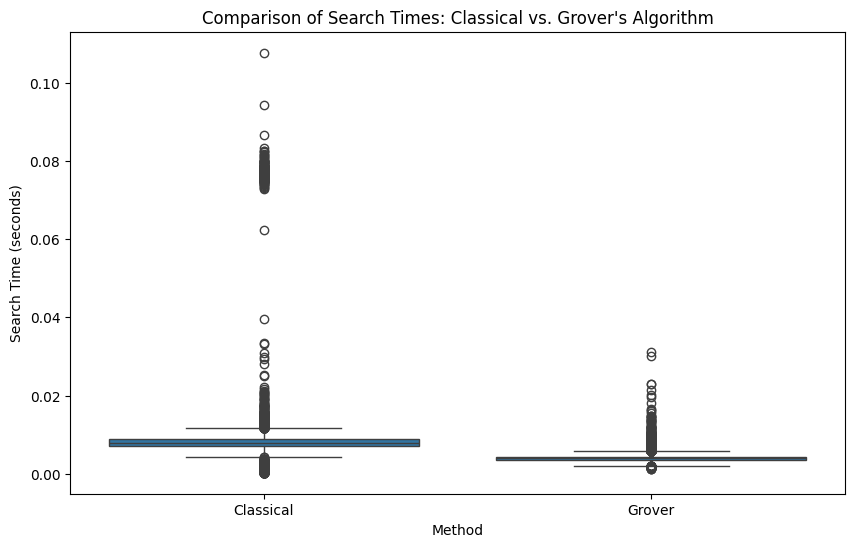

In [25]:
# Function to retrieve 'TimeTaken' values from the MongoDB collection
def get_search_times(collection_name):
    collection = db[collection_name]
    search_results = collection.find()  # Retrieve all documents from the collection
    # Use 'TimeTaken' or another field name that you find in the document structure
    times = [record.get('TimeTaken', 0) for record in search_results]  # Use 0 if 'TimeTaken' is missing
    return times

# Retrieve search times from the collections
classical_times_50 = get_search_times('classical_search_50')
classical_times_500 = get_search_times('classical_search_500')
classical_times_5000 = get_search_times('classical_search_5000')

grover_times_50 = get_search_times('grover_search_50')
grover_times_500 = get_search_times('grover_search_500')
grover_times_5000 = get_search_times('grover_search_5000')

# Combine the search times into one list
classical_times = classical_times_50 + classical_times_500 + classical_times_5000
grover_times = grover_times_50 + grover_times_500 + grover_times_5000

# Create a DataFrame for both classical and Grover search methods
df_comparison = pd.DataFrame({
    'Search Time (seconds)': classical_times + grover_times,
    'Method': ['Classical'] * len(classical_times) + ['Grover'] * len(grover_times)
})

# Calculate the average time for each method
average_classical_time = sum(classical_times) / len(classical_times)
average_grover_time = sum(grover_times) / len(grover_times)

# Print the average times for comparison
print(f"Average time for Classical Search: {average_classical_time:.2f} seconds")
print(f"Average time for Grover's Algorithm: {average_grover_time:.2f} seconds")

# Plot comparison with boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Method', y='Search Time (seconds)', data=df_comparison)
plt.title('Comparison of Search Times: Classical vs. Grover\'s Algorithm')
plt.ylabel('Search Time (seconds)')
plt.show()


Boxplot: Comparison of Search Times
This boxplot shows the distribution of search times for Classical and Grover's algorithms across all dataset sizes.

Insights:
Classical search has a significantly higher median time and a wider spread, indicating more variability and slower performance overall.
Grover's algorithm exhibits a smaller spread and consistently faster search times.

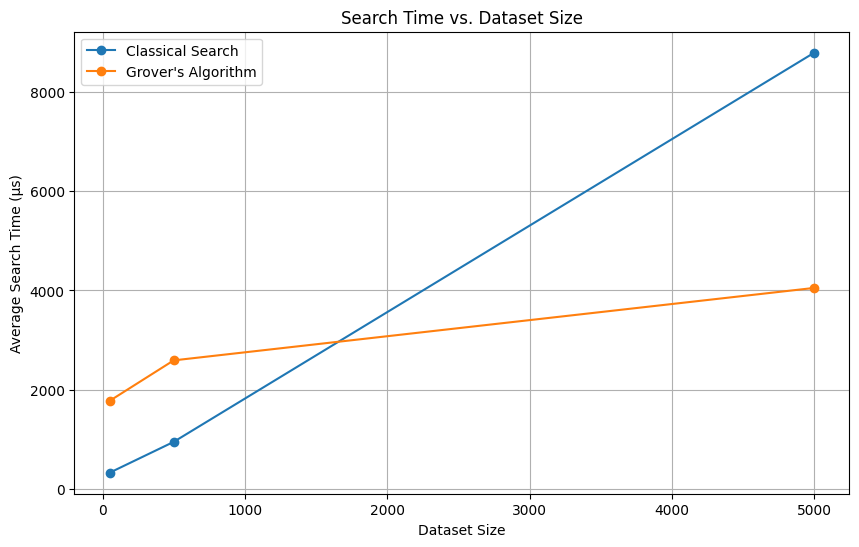

In [19]:
sizes = [50, 500, 5000]
classical_avg_times = [
    np.mean(classical_times_50),
    np.mean(classical_times_500),
    np.mean(classical_times_5000),
]
grover_avg_times = [
    np.mean(grover_times_50),
    np.mean(grover_times_500),
    np.mean(grover_times_5000),
]

plt.figure(figsize=(10, 6))
plt.plot(sizes, classical_avg_times, label="Classical Search", marker="o")
plt.plot(sizes, grover_avg_times, label="Grover's Algorithm", marker="o")
plt.xlabel("Dataset Size")
plt.ylabel("Average Search Time (µs)")
plt.title("Search Time vs. Dataset Size")
plt.legend()
plt.grid()
plt.show()


 Line Graph: Search Time vs. Dataset Size
This graph compares the average search time for both algorithms as the dataset size increases (50, 500, 5000).

Insights:
Classical search shows a linear increase in search time, consistent with its O(N) complexity.
Grover's algorithm grows much slower, following its O(√N) complexity.
The gap between the two algorithms widens as the dataset size increases, demonstrating Grover's advantage for larger datasets.


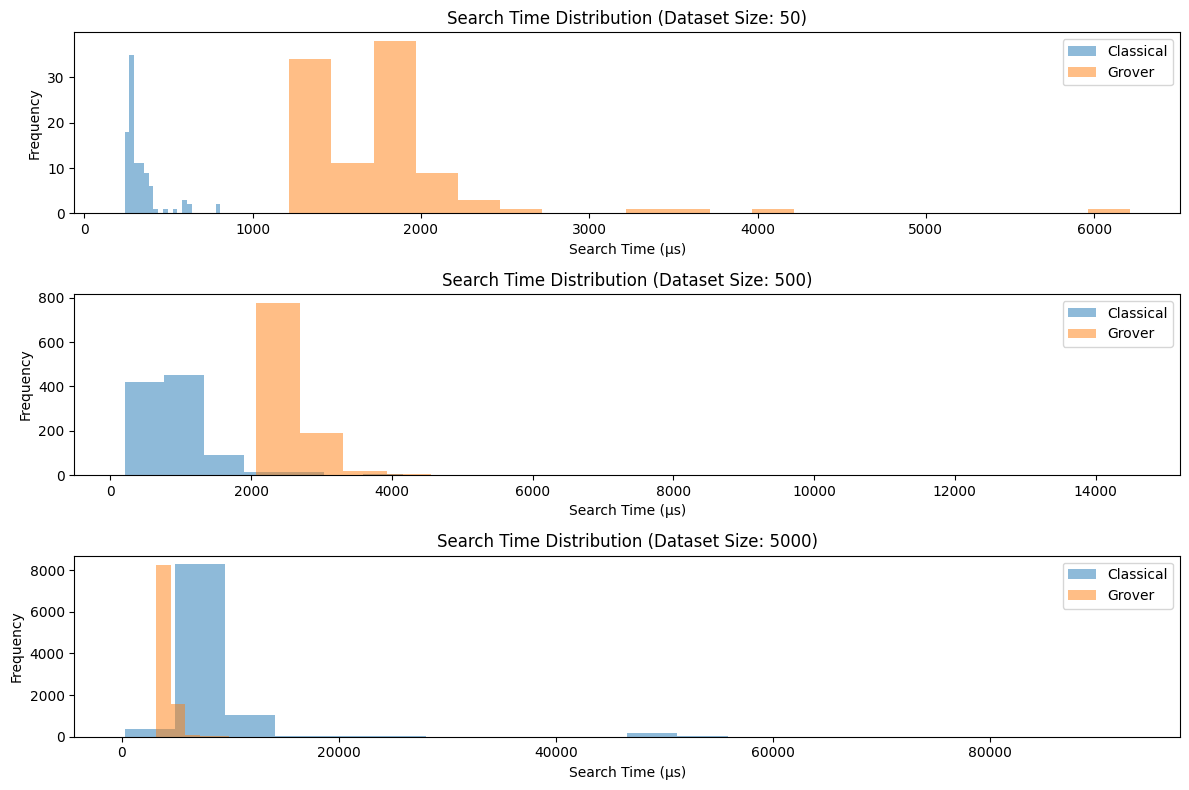

In [20]:
plt.figure(figsize=(12, 8))
for i, (classical, grover, size) in enumerate(
    zip([classical_times_50, classical_times_500, classical_times_5000],
        [grover_times_50, grover_times_500, grover_times_5000],
        sizes)):
    plt.subplot(3, 1, i + 1)
    plt.hist(classical, alpha=0.5, label="Classical", bins=20)
    plt.hist(grover, alpha=0.5, label="Grover", bins=20)
    plt.title(f"Search Time Distribution (Dataset Size: {size})")
    plt.xlabel("Search Time (µs)")
    plt.ylabel("Frequency")
    plt.legend()
plt.tight_layout()
plt.show()


Histograms: Search Time Distributions for Each Dataset Size
Each subplot compares the distributions of search times for Classical and Grover's algorithms for dataset sizes 50, 500, and 5000.

Insights:
Classical search has a broader and more variable distribution across all dataset sizes.
Grover's algorithm has tighter distributions, with fewer extreme values.
For larger datasets, Classical search times shift significantly higher, while Grover's remain more stable.